In [1]:
import numpy as np
import pandas as pd
import csv
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
import seaborn as sns
import sys

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
'''
Utility Functions
'''
# DATA: months since 2012, X coord, Y coord
# if split size = 0, do non
def split(X, tr_size):
    n_col = np.shape(X)[1]
    if tr_size != 0:
        Y = np.copy(X)
        np.random.shuffle(Y)
        break_pt = tr_size * np.shape(X)[0]
        train, test = Y[:break_pt,:], Y[break_pt:,:]
    else:
        break_pt = (3500./4400.) * np.shape(X)[0]
        train, test = X[:break_pt,:], X[break_pt:,:]

    tr_t, te_t = train[:,n_col-1], test[:,n_col-1]
    tr, te = train[:,range(n_col-1)], test[:,range(n_col-1)]
    return tr, tr_t, te, te_t

# implementation notes: set NaN to mean
def normalize_features(X_train):
    mean_X_train = np.nanmean(X_train, 0)
    for i in xrange(np.shape(X_train)[1]):
        col = X_train[:,i]
        col[ np.isnan(col) ] = mean_X_train[i]
    std_X_train = np.std(X_train, 0)
    std_X_train[ std_X_train == 0 ] = 1
    X_train_normalized = (X_train - mean_X_train) / std_X_train
    return X_train_normalized

# Note: bucket edits in place
def bucket(X, cols, num_buckets):
    Y = np.copy(X)
    for col in cols:
        buckets = np.linspace(np.min(X[:,col]), np.max(X[:,col]), num=num_buckets+1)
        for i in xrange(num_buckets):
            X_col = Y[:,col]
            X_col[ (buckets[i] <= X_col) & (X_col <= buckets[i+1])] = i
            Y[:,col] = X_col
    return Y

def rmse(predict, true):
    return np.sqrt(1.0/np.shape(predict)[0] * np.sum(np.square(predict - true)))

In [3]:
'''
Read in data
'''

import re
import warnings

bos_file = '../data/boston.csv'
target_type = str  # The desired output type

with warnings.catch_warnings(record=True) as ws:
    warnings.simplefilter("always")

    bos_data = pd.read_csv(bos_file, sep=",", header=0)
    print("Warnings raised:", ws)
    # We have an error on specific columns, try and load them as string
    for w in ws:
        s = str(w.message)
        print("Warning message:", s)
        match = re.search(r"Columns \(([0-9,]+)\) have mixed types\.", s)
        if match:
            columns = match.group(1).split(',') # Get columns as a list
            columns = [int(c) for c in columns]
            print("Applying %s dtype to columns:" % target_type, columns)
            bos_data.iloc[:,columns] = bos_data.iloc[:,columns].astype(target_type)

'''
Featurize data
'''
# temporal features
# day of week
day = np.array(bos_data.DAY_WEEK)
day[ day == "Sunday"] = 0
day[ day == "Monday"] = 1
day[ day == "Tuesday"] = 2
day[ day == "Wednesday"] = 3
day[ day == "Thursday"] = 4
day[ day == "Friday"] = 5
day[ day == "Saturday"] = 6

# Split mm/dd/yyyy xx:yy:zz AM/PM into components
date_time = np.array([x.split() for x in bos_data.FROMDATE])
date = date_time[:,0]
time = date_time[:,1]
tod = date_time[:,2]

# month, day, year
date = np.array([x.split('/') for x in date])
month = [int(x) for x in date[:,0]]
dom = [int(x) for x in date[:,1]]
year = [int(x) for x in date[:,2]]
# months since Jan 2012
time_feat = np.subtract(year, 2012)*12 + month

# time of day
time_c = [x.split(':') for x in time]
time = [int(x[1]) if (y == 'AM' and int(x[0]) == 12) else 60*int(x[0])+int(x[1]) 
        if (y =='AM' and int(x[0]) != 12) or (int(x[0]) == 12 and y == 'PM') else 12*60+60*int(x[0])+int(x[1]) 
        for x,y in zip(time_c, tod)]

# grab the features we want
data_unnorm = np.transpose(np.vstack((time_feat, bos_data.X, bos_data.Y))).astype(float)
# remove NaNs
good_data = data_unnorm[~(np.isnan(data_unnorm[:,1]))]

('Warnings raised:', [<warnings.WarningMessage object at 0x7fd719a13310>])
('Warning message:', 'Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.')
("Applying <type 'str'> dtype to columns:", [10])


In [4]:
len(good_data)

253075

In [5]:
'''
Count data for each cell. If logSpace is true, returns log values.
'''
def createBuckets(n_buckets = 15, logSpace = True):
    data_b = bucket(good_data, [1, 2], n_buckets)

    years = [2012, 2013, 2014, 2015]
    n_time = int(data_b[np.argmax(data_b[:,0])][0])

    # buckets = np.zeros((n_time, n_buckets, n_buckets))
    buckets2 = np.zeros((n_buckets * n_buckets * n_time, 4))

    # divide the data up by year and month
    for i in xrange(n_time):
        for j in xrange(n_buckets):
            for k in xrange(n_buckets):
                count = data_b[ (data_b[:,0] == i+1) & 
                                (data_b[:,1] == j) & 
                                (data_b[:,2] == k)]
                # buckets[i][j][k] = np.size(count,0)
                buckets2[i*(n_buckets * n_buckets)+j*(n_buckets)+k][0] = i
                buckets2[i*(n_buckets * n_buckets)+j*(n_buckets)+k][1] = j
                buckets2[i*(n_buckets * n_buckets)+j*(n_buckets)+k][2] = k
                buckets2[i*(n_buckets * n_buckets)+j*(n_buckets)+k][3] = np.size(count,0)
    print np.shape(buckets2)
    
    if logSpace:
        buckets2[:,3] = np.log(np.add(sys.float_info.epsilon, buckets2[:,3]))
    
    return buckets2

In [18]:
'''
Our GP
    other implementations:
    - scikit-learn
    - GPy
'''

# compute the kernel matrix
# use square exponential by default
def ker_se(x, y, l, horz = 1.0):
    
    n = np.shape(x)[0]
    m = np.shape(y)[0]
    
    t = np.reshape(x, (np.shape(x)[0], 1, np.shape(x)[1]))
    s = np.reshape(y, (1, np.shape(y)[0], np.shape(y)[1]))

    # tile across columns
    cols = np.tile(t, (1, m, 1))
    # tile across rows
    rows = np.tile(s, (n, 1, 1))
    # get the differences and vectorize
    diff_vec = np.reshape(cols - rows, (n*m, np.shape(t)[2]))
    
    M = np.diag(l)
    
    # use multiply and sum to calculate matrix product
    s = np.multiply(-.5, np.sum(np.multiply(diff_vec, np.transpose(np.dot(M, np.transpose(diff_vec)))), axis=1))
    se = np.reshape(np.multiply(horz, np.exp(s)), (n, m))
    
    return se

# p is wavelength
def ker_per(x, y, l, p, horz = 1.0):
    
    n = np.shape(x)[0]
    m = np.shape(y)[0]
    
    t = np.reshape(x, (np.shape(x)[0], 1, np.shape(x)[1]))
    s = np.reshape(y, (1, np.shape(y)[0], np.shape(y)[1]))

    # tile across columns
    cols = np.tile(t, (1, m, 1))
    # tile across rows
    rows = np.tile(s, (n, 1, 1))
    # get the differences and vectorize
    diff_vec = np.reshape(cols - rows, (n*m, np.shape(t)[2]))
    
    P = np.diag(p)
    M = np.diag(l)
    
    # sig^2 exp{ -.5 sum( (sin(pi/p |x - x'|)/l)^2 ) }
    sin = np.square(np.dot(np.sin(np.dot(np.multiply(np.pi, diff_vec), P)), M))
    exp = np.multiply(-.5, np.sum(sin, axis=1))
    #print np.sum(sin, axis=1)
    per = np.reshape(np.multiply(horz, np.exp(exp)), (n, m))
    
    return per

In [21]:
t = ker_per(train, train, np.ones(3), np.ones(3)*.5)
print t

[  0.00000000e+00   1.00000000e+00   1.49975978e-32 ...,   1.49975978e-32
   1.00000000e+00   0.00000000e+00]
[[ 1.          0.60653066  1.         ...,  0.36787944  0.60653066
   0.36787944]
 [ 0.60653066  1.          0.60653066 ...,  0.60653066  0.36787944
   0.60653066]
 [ 1.          0.60653066  1.         ...,  0.36787944  0.60653066
   0.36787944]
 ..., 
 [ 0.36787944  0.60653066  0.36787944 ...,  1.          0.60653066  1.        ]
 [ 0.60653066  0.36787944  0.60653066 ...,  0.60653066  1.          0.60653066]
 [ 0.36787944  0.60653066  0.36787944 ...,  1.          0.60653066  1.        ]]


In [29]:
kern = gp.kern.StdPeriodic(input_dim=3, wavelength=np.ones(3), lengthscale=np.ones(3)*2, ARD1 = True, ARD2 = True)
k = kern.K(train)

In [30]:
print k
print t

[[ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 ..., 
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]]
[[ 1.          0.60653066  1.         ...,  0.36787944  0.60653066
   0.36787944]
 [ 0.60653066  1.          0.60653066 ...,  0.60653066  0.36787944
   0.60653066]
 [ 1.          0.60653066  1.         ...,  0.36787944  0.60653066
   0.36787944]
 ..., 
 [ 0.36787944  0.60653066  0.36787944 ...,  1.          0.60653066  1.        ]
 [ 0.60653066  0.36787944  0.60653066 ...,  0.60653066  1.          0.60653066]
 [ 0.36787944  0.60653066  0.36787944 ...,  1.          0.60653066  1.        ]]


In [7]:
'''
Calculate kernels
'''
def GaussianProcess(train, train_t, test, test_t, l,
                    horz, sig_eps, predict=True, rmse=True, ker='se'):
    # Try to be memory efficient by deleting data after use!
    if ker == 'se':
        ker_fun = ker_se
    else:
        raise Exception("Kernal {} Not Supported!".format(ker))
        
    ker1 = ker_fun(train, train, l, horz)
    L = np.linalg.cholesky(ker1 + np.multiply(sig_eps, np.identity(np.shape(ker1)[0])))
    
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, train_t))
    
    # Only do this if we request the predictions or rmse
    ret = []
    if predict or rmse:
        ker2 = ker_fun(train,test, l, horz)
        preds = np.dot(np.transpose(ker2), alpha)
        del ker2
        ret.append(preds)
        
    
    # Only if we request the rmse
    if rmse:
        npreds = preds / float(preds.sum())
        ntest_t = test_t / float(test_t.sum())
        rmse_val = np.sqrt(np.sum(np.square(npreds - ntest_t))/np.shape(preds)[0])
        print rmse
        ret.append(rmse_val)
        
    # Calculate the marginal likelihood
    likelihood = -.5 * np.dot(np.transpose(train_t), alpha) - np.sum(np.log(np.diagonal(L))) - np.shape(ker1)[0]/2 * np.log(2*np.pi)
    ret.append(likelihood)
    
    del alpha
    del L
    del ker1
    
    return tuple(ret)


In [7]:
columns = { 't' : 0, 'x' : 1, 'y' : 2, 'count' : 3}
def createHeatMap(X):
    '''
    Given a data set, creates a heatmap of it based on x,y coordinates.
    Ignore the temporal feature. You should subset the data before passing
    it into this function if you'd like a heatmap for a specific time period.
    '''
    n = X[:, columns['x']].astype(int).max()
    m = X[:, columns['y']].astype(int).max()
    heatmap = np.zeros((n,m))
    for i in xrange(n):
        for j in xrange(m):
            total = X[(X[:, columns['x']] == i) & 
                      (X[:, columns['y']] == j), columns['count']].sum()
            if total > 0:
                heatmap[i,j] = total
    heatmap = heatmap / float(heatmap.sum())
    return heatmap

In [8]:
# Make some plots for n = 15 for GP process
def plotDistribution(predict, true, city, n, process='GP'):
    minValue = min(len(predict), 100)
    yPred = predict[-minValue:]
    yTrue = true[-minValue:]
    yPred = yPred / float(np.sum(yPred))
    yTrue = yTrue / float(np.sum(yTrue))
    plt.clf()
    plt.plot(yPred, label="Predictions")
    plt.plot(yTrue, label="Actual Data")
    plt.title('Predictive Distribution for {}'.format(process))
    plt.xlabel('Compressed Features')
    plt.ylabel('Probability')
    plt.legend()
    plt.savefig('../figures/{}_results/{}_n={}_periods={}.png'.format(
        city, process, n,12))
    plt.close()

In [9]:
def plotHeatMaps(X_test, predict, city, n, process='GP'):
    # Attach the predictions to the data
    trueValues = np.copy(X_test)
    predictedValues = np.copy(X_test)
    predictedValues[:, columns['count']] = predict

    # Now we want to plot the heatmaps for the predictions/actual data
    # by time period
    months = np.unique(X_test[:, columns['t']])
    for month in months:
        # Create the heatmaps 
        selected = (X_test[:, columns['t']] == month)
        if selected.sum() > 0:
            plt.clf()
            m = createHeatMap(trueValues[selected, :])
            if m.sum() > 0:
                sns.heatmap(m)
                plt.title('True Density Distribution in Month {}'.format(month))
                plt.savefig('../figures/{}_results/{}_heatmap_true_n={}_t={}.png'.format(
                    city, process, n, month))
                plt.close()

            plt.clf()
            m = createHeatMap(predictedValues[selected, :])
            if m.sum() > 0:
                sns.heatmap(m)
                plt.title('Predicted Density Distribution in Month {}'.format(month))
                plt.savefig('../figures/{}_results/{}_heatmap_pred_n={}_t={}.png'.format(
                    city, process, n, month))
                plt.close()

In [10]:
log = False
%time data = createBuckets(n_buckets=10, logSpace=log)  # default is 15, logSpace=True
%time train, train_t, test, test_t = split(data, 0)
sig_eps = train_t.std()

(4400, 4)
CPU times: user 14.4 s, sys: 0 ns, total: 14.4 s
Wall time: 14.4 s
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.93 ms


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [ ]:
# These are the optimal parameters for n = 10 (we can try with other values too)
l = [9620.11949755, 9620.11949755, 9620.11949755]
horz = 0.82754075018
sig_eps = train_t.std()
%time predictions, rmse, likelihood = GaussianProcess(train, train_t, test, test_t, l, horz, sig_eps)

In [ ]:
# Only do the below if logspace !
if log:
    test_t = np.exp(test_t)
    predictions = np.exp(predictions)

In [ ]:
plotDistribution(predictions, test_t, 'boston', 15, process='GPSEOptimzied')

In [ ]:
np.diag([1,2,3])

In [69]:
X_test = np.zeros((test.shape[0], test.shape[1] + 1)).astype(int)
X_test[:,:-1] = test
X_test[:,-1] = test_t

In [ ]:
plotHeatMaps(X_test, predictions, 'boston', 15, process='GPSELog')

In [ ]:
'''
Easier method for calling our GP model! Kernal defaults to SE.
'''
def optimizeGaussianProcess(n, l1, l2, l3, horz, sig_eps,
                            log=False):
    # Bucketize the data as specified! By default, does Boston data.
    data = createBuckets(n, logSpace=log)
    
    # Split for latest year.
    train, train_t, test, test_t = split(data, 0)
    
    # Calculate the likelihood
    l = [l1,l2,l3]
    likelihood = GaussianProcess(train, train_t, test, test_t,
                                 l, horz, sig_eps,
                                 predict = False, rmse = False)
    return likelihood

In [ ]:
# Collect likelihoods for different n values
testN = range(2,10) + range(10,20,5)
likelihoods = []
for n in testN:
    likelihood = optimizeGaussianProcess(n, 1.0, 1.0, 1.0, 1.0, 1.0,
                                        log=False)
    likelihoods.append(likelihood)

In [ ]:
x = testN
y = likelihoods
line1 = plt.plot(x, y, label="Log Likelihood")
plt.title('GP Predictions for Boston')
plt.xlabel('Dimension of Grid')
plt.ylabel('Log Likelihood')
plt.legend()
plt.show()

In [11]:
train_t = train_t.reshape((train_t.shape[0], 1))

In [12]:
'''
Smart GP
'''

import GPy as gp

In [13]:
kern = gp.kern.RBF(input_dim=3, variance=1., lengthscale=1.)

In [14]:
from IPython.display import display

In [15]:
train_t = train_t.reshape((train_t.shape[0], 1))
%time m = gp.models.GPRegression(train, train_t, kern)

CPU times: user 35.8 s, sys: 228 ms, total: 36 s
Wall time: 36 s


In [23]:
display(m)

GP_regression.,Value,Constraint,Prior,Tied to
rbf.variance,9620.11949755,+ve,,
rbf.lengthscale,0.82754075018,+ve,,
Gaussian_noise.variance,121.977861302,fixed,,


In [17]:
# We fix the Gaussian_noise.variance to the std of the training data!
m.Gaussian_noise.variance.constrain_fixed(train_t.std())

array([0])

In [18]:
display(m)

GP_regression.,Value,Constraint,Prior,Tied to
rbf.variance,1.0,+ve,,
rbf.lengthscale,1.0,+ve,,
Gaussian_noise.variance,121.977861302,fixed,,


In [19]:
# We're going to constrain some 
m.optimize(messages=True, max_iters=100)
# Total of 110 iterations are being run :)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
 01m41s33  003   1.828626e+05   1.036901e+08 
 06m17s03  011   1.132581e+05   4.204292e+06 
 11m12s18  019   3.683976e+04   1.680878e+06 
 14m30s40  023   2.332072e+04   1.253264e+05 
 16m51s87  026   2.043403e+04   8.851823e+02 
 21m58s19  033   1.957740e+04   5.003234e+02 
 25m00s42  037   1.956880e+04   1.271713e-04 
 26m28s39  039   1.956880e+04   3.079244e-09 
Runtime:  26m28s39
Optimization status: Converged



 /usr/local/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning:The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.


In [20]:
display(m)

GP_regression.,Value,Constraint,Prior,Tied to
rbf.variance,9620.11949755,+ve,,
rbf.lengthscale,0.82754075018,+ve,,
Gaussian_noise.variance,121.977861302,fixed,,


In [21]:
predictions_optimal = m.predict(test)

In [22]:
preds2 = predictions_optimal[0]

In [ ]:
plotDistribution(preds2, test_t, 'boston', 10, process='GPSEOptimized2')

In [24]:
len(preds2), len(test_t)

(900, 900)

In [25]:
process = 'GPSEOptimzed2'
city = 'boston'
n = 10
minValue = min(len(preds2), 100)
yPred = preds2[-minValue:]
yTrue = test_t[-minValue:]
yPred = yPred / float(np.sum(yPred))
yTrue = yTrue / float(np.sum(yTrue))

In [26]:
plt.clf()
plt.plot(yPred, label="Predictions")
plt.plot(yTrue, label="Actual Data")
plt.title('Predictive Distribution for {}'.format('process'))
plt.xlabel('Compressed Features')
plt.ylabel('Probability')
plt.legend()
plt.savefig('../figures/{}_results/{}_n={}_periods={}.png'.format(
    city, process, n,12))
plt.close()

In [28]:
plt.plot(yPred)

In [32]:
% matplotlib inline
plt.show()

In [31]:
plt.close()

In [33]:
test_t

array([   0.,   11.,   33.,   18.,    4.,    0.,   18.,   41.,    0.,
          0.,    5.,   21.,   37.,   52.,    0.,    0.,  112.,  142.,
          2.,    0.,   46.,  101.,   81.,  115.,   38.,   14.,    4.,
        149.,    0.,    0.,    0.,   24.,  115.,   34.,  115.,  251.,
        209.,   26.,    0.,    0.,    0.,    0.,  127.,  362.,  394.,
        402.,  512.,  245.,    0.,   11.,    0.,    0.,   57.,  235.,
        364.,  255.,  220.,  655.,  204.,   15.,    0.,    0.,    3.,
         37.,    7.,   46.,  137.,   24.,  187.,   38.,    0.,    0.,
          0.,    0.,    0.,    0.,    6.,    1.,   11.,   49.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,   12.,
          0.,    0.,    0.,    0.,    2.,    0.,    0.,    0.,    0.,
          0.,    0.,    4.,   19.,   22.,    3.,    0.,   17.,   30.,
          0.,    0.,    7.,   30.,   30.,   45.,    1.,    0.,   78.,
        145.,    1.,    0.,   35.,  135.,   88.,   91.,   34.,    4.,
          6.,  124.,

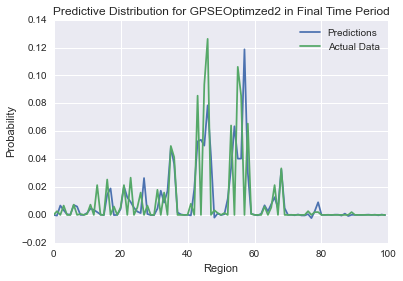

In [74]:
yPred = preds2[-minValue:]
yTrue = test_t[-minValue:]
yPred = yPred / float(np.sum(yPred))
yTrue = yTrue / float(np.sum(yTrue))
plt.plot(yPred, label="Predictions")
plt.plot(yTrue, label="Actual Data")
plt.title('Predictive Distribution for {} in Final Time Period'.format(process))
plt.xlabel('Region')
plt.ylabel('Probability')
plt.legend()

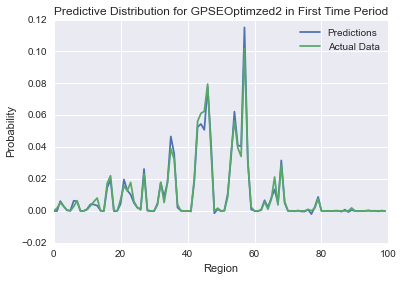

In [77]:
yPred = preds2[:minValue]
yTrue = test_t[:minValue]
yPred = yPred / float(np.sum(yPred))
yTrue = yTrue / float(np.sum(yTrue))
plt.plot(yPred, label="Predictions")
plt.plot(yTrue, label="Actual Data")
plt.title('Predictive Distribution for {} in First Time Period'.format(process))
plt.xlabel('Region')
plt.ylabel('Probability')
plt.legend()

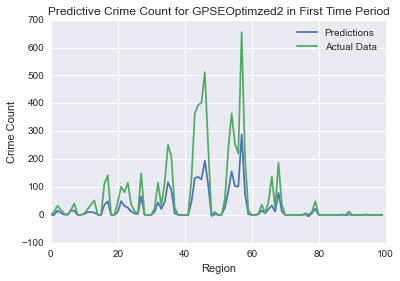

In [78]:
yPred = preds2[:minValue]
yTrue = test_t[:minValue]
plt.plot(yPred, label="Predictions")
plt.plot(yTrue, label="Actual Data")
plt.title('Predictive Crime Count for {} in First Time Period'.format(process))
plt.xlabel('Region')
plt.ylabel('Crime Count')
plt.legend()

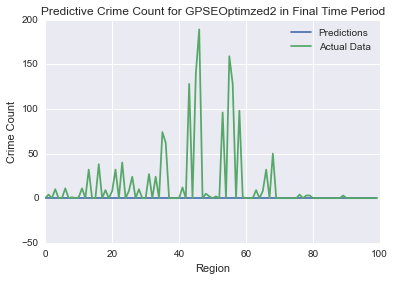

In [79]:
yPred = preds2[-minValue:]
yTrue = test_t[-minValue:]
plt.plot(yPred, label="Predictions")
plt.plot(yTrue, label="Actual Data")
plt.title('Predictive Crime Count for {} in Final Time Period'.format(process))
plt.xlabel('Region')
plt.ylabel('Crime Count')
plt.legend()

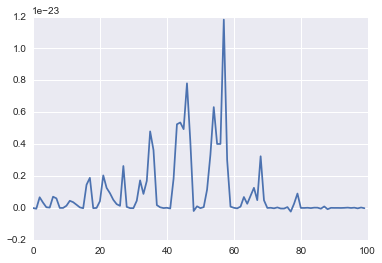

In [53]:
plt.plot(preds2[len(preds2) - 100:])

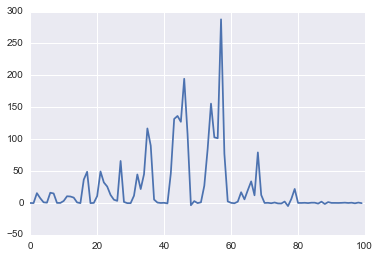

In [67]:
plt.plot(preds2[:100])

In [85]:
selected = []
for i in range(100):
    selected.append(range(i,len(preds2),100))

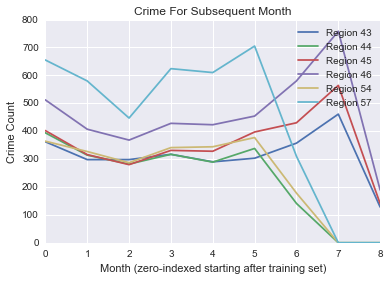

In [91]:
for i in range(100):
    data = preds2[selected[i]]
    if data.sum() > 140:
        plt.plot(test_t[selected[i]], label='Region {}'.format(i))
        # plt.plot(test_t[selected[i]], label='Actual Region {}'.format(i))
plt.title('Crime For Subsequent Month')
plt.xlabel('Month (zero-indexed starting after training set)')
plt.ylabel('Crime Count')
plt.legend()

In [70]:
# Attach the predictions to the data
trueValues = np.copy(X_test)
predictedValues = np.copy(X_test)
predictedValues[:, columns['count']] = preds2

In [71]:
# Now we want to plot the heatmaps for the predictions/actual data
# by time period
months = np.unique(X_test[:, columns['t']])
for month in months:
    # Create the heatmaps 
    selected = (X_test[:, columns['t']] == month)
    if selected.sum() > 0:
        plt.clf()
        m = createHeatMap(trueValues[selected, :])
        if m.sum() > 0:
            sns.heatmap(m)
            plt.title('True Density Distribution in Month {}'.format(month))
            plt.savefig('../figures/{}_results/{}_heatmap_true_n={}_t={}.png'.format(
                city, process, n, month))
            plt.close()

        plt.clf()
        m = createHeatMap(predictedValues[selected, :])
        if m.sum() > 0:
            sns.heatmap(m)
            plt.title('Predicted Density Distribution in Month {}'.format(month))
            plt.savefig('../figures/{}_results/{}_heatmap_pred_n={}_t={}.png'.format(
                city, process, n, month))
            plt.close()

 /usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning:elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
